In [185]:
#main problem 
import numpy as np
import matplotlib.pyplot as plt
import torch 
from numpy.linalg import matrix_power
N=500
alpha=5
s=1/(2*alpha)
A=torch.zeros((N,N))

for i in range(0,N-1):
    A[i,i]=1-2*s
    A[i,i-1]=s
    A[i,i+1]=s
    

A[0,-1]=0
A[-1,-1]=1-2*s
A[-1,-2] = s

u=torch.zeros((N,1))


k = np.random.randint(0,N-50,10)
u[k+25] = 50*torch.randn(10,1)
u = np.cumsum(u)
if np.linalg.norm(u[u<0])<np.linalg.norm(u[u>0]):
    u[u<0]=0
else:
    u[u>0] =0 
    u = -u
Ncount=1000
u[:60]=0
u[-60:]=0

Fw=torch.matrix_power(A, Ncount)
meas=Fw@u
noise = torch.randn(meas.shape)*1
measn= meas+noise

Define linear kernel:

In [186]:
c = np.stack([np.linspace(0,30,30),np.linspace(30,0,30)],axis=1).T.reshape(60,1)[:,0]

Use the linear kernel to generate measurement

In [187]:
# linear filter
meas1 = u.clone()
for i in range(440):
    meas1[i+30] = u[i:(i+60)].dot(torch.from_numpy(c).type(dtype=torch.float32))/sum(c)

Define constant/moving window kernel and the corresponding measurement

In [188]:
# moving window filter
meas2 = u.clone()
for i in range(440):
    meas2[i+30] = torch.mean(u[i:(i+60)])

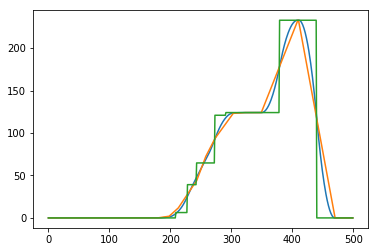

In [189]:
plt.plot(meas1.numpy())
plt.plot(meas2.numpy())
plt.plot(u.numpy())

Define a function to compute PSNR 

In [97]:
# function that computes the psnr, first input is the original, second input is reconstructed
def psnr1(A,B):
    MSE = torch.mean((A-B)**2)**0.5
    return 20*np.log(torch.max(torch.abs(A))/MSE)/np.log(10)

The PSNR of the measurement (without running any reconstruction algorithm)

In [190]:
print('PSNR of linear filter (no reconstruction):{:f}'.format(psnr1(u,meas1)))
print('PSNR of constant filter (no reconstruction):{:f}'.format(psnr1(u,meas2)))

PSNR of linear filter (no reconstruction):21.161541
PSNR of constant filter (no reconstruction):18.902170


Run the naive TV reconstruction

In [147]:
import cvxpy as cp
D = np.diag(np.ones((N,1))[:,0],0)-np.diag(np.ones((N-1,1))[:,0],-1)
D[-2,-1]=0

PSNR of linear filter (naive TV reconstruction):21.161200
PSNR of constant filter (naive TV reconstruction):18.901623


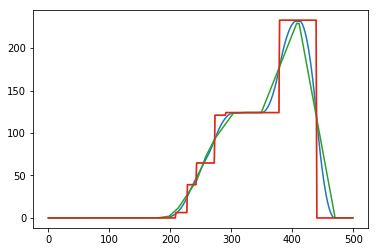

In [191]:
#
def naive_TV(meas):
    x_l1 = cp.Variable(shape=(N,1))
    constraints = [x_l1>=0] 
    obj = cp.Minimize(cp.norm(D@x_l1, 1) + cp.norm(x_l1[:,0]-meas, 2)**2*1e-1)
    prob = cp.Problem(obj, constraints)
    prob.solve()
    x2 = torch.from_numpy(x_l1.value[:,0]).cpu().type(dtype=torch.float32)
    plt.plot(x_l1.value)
    plt.plot(u)
    return psnr1(u,x_l1.value.T)
print('PSNR of linear filter (naive TV reconstruction):{:f}'.format(naive_TV(meas1)))
print('PSNR of constant filter (naive TV reconstruction):{:f}'.format(naive_TV(meas2)))

Define deconvolution solver

In [192]:
def l1solv(Fw1,meas):
# Create variable.
   x_l1 = cp.Variable(shape=(N,1))
   constraints = [x_l1>=0] #, cp.norm(Fw1.numpy()@x_l1-meas, 2)<=torch.norm(noise)]
# Form objective.
   obj = cp.Minimize(cp.norm(D@x_l1, 1)+ cp.norm((Fw1.numpy()@x_l1)[:,0]-meas, 2)*1e1)
# Form and solve problem.
   prob = cp.Problem(obj, constraints)
   prob.solve()
   x2 = torch.from_numpy(x_l1.value[:,0]).cpu().type(dtype=torch.float32)
   plt.plot(x_l1.value)
   plt.plot(u)
   mx_norm = torch.norm(torch.from_numpy(D@x_l1.value[:,0]), 0.5)**0.5+(torch.norm(torch.from_numpy(D@x_l1.value[:,0]), 2))**2*2e-4
   psnr_recon = psnr1(u,x_l1.value.T)
   print('psnr:{:f}, mixednorm:{:f}'.format(psnr_recon,mx_norm))
   return mx_norm, psnr_recon

Search for Ncount for the **linear filter**

psnr:21.657819, mixednorm:139.825656
psnr:22.297540, mixednorm:110.949794
psnr:22.708975, mixednorm:97.241367
psnr:21.947765, mixednorm:94.577269
psnr:21.090139, mixednorm:86.805485
psnr:22.782906, mixednorm:80.340028
psnr:31.162245, mixednorm:77.372621
psnr:28.920429, mixednorm:76.464123
psnr:24.416303, mixednorm:76.547721
psnr:22.405066, mixednorm:78.197099
psnr:20.719878, mixednorm:78.011737
psnr:19.794830, mixednorm:82.427487
psnr:19.101054, mixednorm:83.400486
psnr:17.963117, mixednorm:84.756945
psnr:17.343410, mixednorm:83.126591
psnr:16.575515, mixednorm:83.600431
psnr:15.487202, mixednorm:86.851333
psnr:14.744217, mixednorm:86.762111
psnr:14.036812, mixednorm:87.106892
psnr:13.388895, mixednorm:94.831869


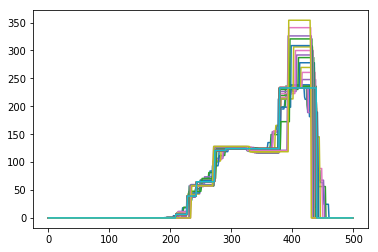

In [193]:
t = np.linspace(100,2400,20)
a =[]
b =[]
for ti in range(20):
    mix_norm, psnr_rec = l1solv(torch.matrix_power(A, int(t[ti])),meas1)
    a.append(mix_norm)
    b.append(psnr_rec)

Reconstruction with best Ncount (the one that minimizes the mixed norm)

psnr:28.920429, mixednorm:76.464123


(tensor(76.4641, dtype=torch.float64), tensor(28.9204, dtype=torch.float64))

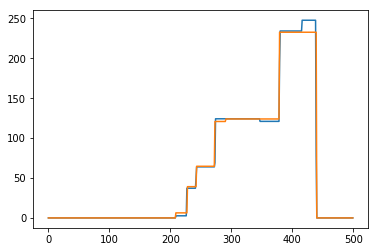

In [194]:
N_recon = np.round(t[a==np.min(a)])
l1solv(torch.matrix_power(A, int(N_recon)),meas1)

Search for Ncount for the **constant filter**, we expect this Ncount to be larger than that for the linear filter.

In [195]:
def l1solv(Fw1,meas):
# Create variable.
   x_l1 = cp.Variable(shape=(N,1))
   constraints = [x_l1>=0] #, cp.norm(Fw1.numpy()@x_l1-meas, 2)<=torch.norm(noise)]
# Form objective.
   obj = cp.Minimize(cp.norm(D@x_l1, 1)+ cp.norm((Fw1.numpy()@x_l1)[:,0]-meas, 2)*1e1)
# Form and solve problem.
   prob = cp.Problem(obj, constraints)
   prob.solve()
   x2 = torch.from_numpy(x_l1.value[:,0]).cpu().type(dtype=torch.float32)
   plt.plot(x_l1.value)
   plt.plot(u)
   mx_norm = torch.norm(torch.from_numpy(D@x_l1.value[:,0]), 0.5)**0.5+(torch.norm(torch.from_numpy(D@x_l1.value[:,0]), 2))*1e-1
   psnr_recon = psnr1(u,x_l1.value.T)
   print('psnr:{:f}, mixednorm:{:f}'.format(psnr_recon,mx_norm))
   return mx_norm, psnr_recon

psnr:17.544201, mixednorm:43.873950
psnr:17.501247, mixednorm:38.714866
psnr:17.381732, mixednorm:35.623187
psnr:17.193923, mixednorm:36.014953
psnr:17.100121, mixednorm:35.118709
psnr:17.135883, mixednorm:36.648373
psnr:17.249384, mixednorm:33.791049
psnr:17.377488, mixednorm:31.810601
psnr:17.525236, mixednorm:32.703446
psnr:17.700691, mixednorm:32.548330
psnr:17.876174, mixednorm:31.069195
psnr:17.955272, mixednorm:32.003193
psnr:18.058454, mixednorm:33.057059
psnr:18.156839, mixednorm:33.843129
psnr:18.262956, mixednorm:34.770845
psnr:18.380445, mixednorm:35.867375
psnr:18.501360, mixednorm:37.174090
psnr:18.603994, mixednorm:38.092034
psnr:18.714805, mixednorm:36.747391
psnr:18.875703, mixednorm:38.220115
psnr:19.081369, mixednorm:41.620445
psnr:19.337616, mixednorm:43.904687
psnr:19.198533, mixednorm:40.945945
psnr:19.173083, mixednorm:42.824422
psnr:19.380534, mixednorm:44.638323
psnr:19.295166, mixednorm:43.474079
psnr:19.231259, mixednorm:43.679616
psnr:19.169924, mixednorm:43

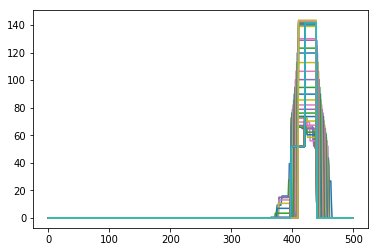

In [183]:
t = np.linspace(100,3500,30)
a =[]
b =[]
for ti in range(30):
    mix_norm, psnr_rec = l1solv(torch.matrix_power(A, int(t[ti])),meas2)
    a.append(mix_norm)
    b.append(psnr_rec)

Reconstruction with best Ncount (the one that minimizes the mixed norm)

psnr:17.876174, mixednorm:31.069195


(tensor(31.0692, dtype=torch.float64), tensor(17.8762, dtype=torch.float64))

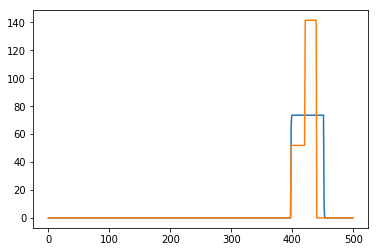

In [184]:
N_recon = np.round(t[a==np.min(a)])
l1solv(torch.matrix_power(A, int(N_recon)),meas2)